In [14]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 1: Connect to PostgreSQL
# -------------------------------
# Replace with your actual credentials locally
engine = create_engine("postgresql+psycopg2://<USERNAME>:<PASSWORD>@localhost:5432/vendor_analysis")

In [16]:
# Step 2: Load cleaned vendor performance data
# -------------------------------
# Adjust query for top/bottom vendors (memory efficient)
query = """
WITH sales_agg AS (
    SELECT s.vendorno AS vendor_id,
           MAX(s.vendorname) AS vendor_name,
           SUM(s.salesdollars) AS total_sales_revenue
    FROM sales s
    WHERE s.salesdollars > 0
    GROUP BY s.vendorno
),
purch_agg AS (
    SELECT vi.vendornumber AS vendor_id,
           MAX(vi.vendorname) AS vendor_name,
           SUM(vi.dollars) AS total_purchase_cost
    FROM vendor_invoice vi
    GROUP BY vi.vendornumber
),
freight_agg AS (
    SELECT vi.vendornumber AS vendor_id,
           SUM(vi.freight) AS total_freight
    FROM vendor_invoice vi
    GROUP BY vi.vendornumber
),
vendor_perf AS (
    SELECT COALESCE(s.vendor_id, p.vendor_id) AS vendor_id,
           COALESCE(s.vendor_name, p.vendor_name) AS vendor_name,
           COALESCE(s.total_sales_revenue, 0)
           - COALESCE(p.total_purchase_cost, 0)
           - COALESCE(f.total_freight, 0) AS profit_incl_freight
    FROM sales_agg s
    FULL OUTER JOIN purch_agg p USING (vendor_id)
    FULL OUTER JOIN freight_agg f USING (vendor_id)
)
SELECT * FROM vendor_perf;
"""

vendor_perf = pd.read_sql(query, engine)

# -------------------------------

In [18]:
# Step 3: Extract Top & Bottom 10
# -------------------------------
top_vendors = vendor_perf.nlargest(10, 'profit_incl_freight')
bottom_vendors = vendor_perf.nsmallest(10, 'profit_incl_freight')

# -------------------------------


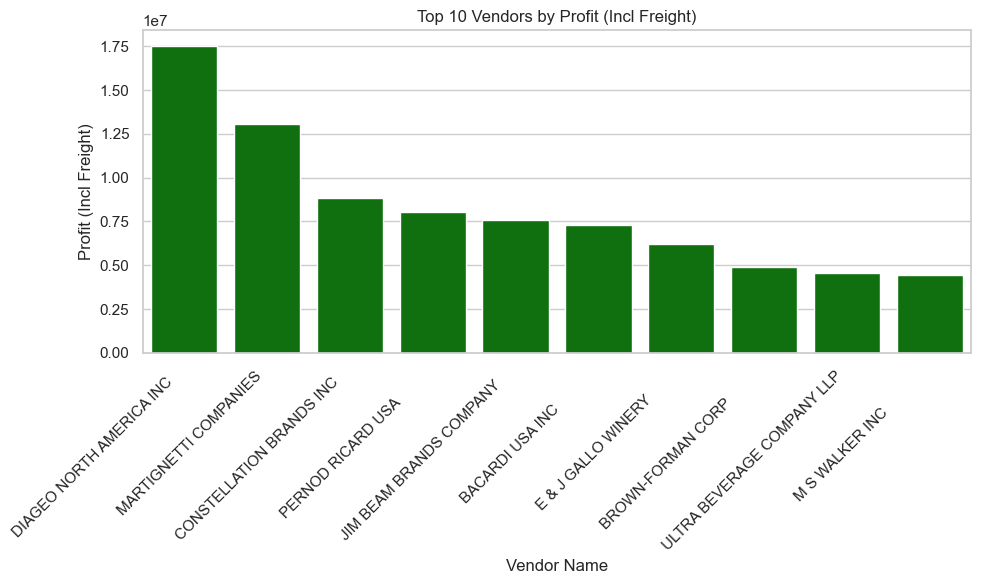

In [19]:
# Step 4: Plot Top 10 Vendors
# -------------------------------
plt.figure(figsize=(10,6))
sns.barplot(
    x='vendor_name',
    y='profit_incl_freight',
    data=top_vendors,
    color='green'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Vendors by Profit (Incl Freight)')
plt.ylabel('Profit (Incl Freight)')
plt.xlabel('Vendor Name')
plt.tight_layout()
plt.show()

# -------------------------------

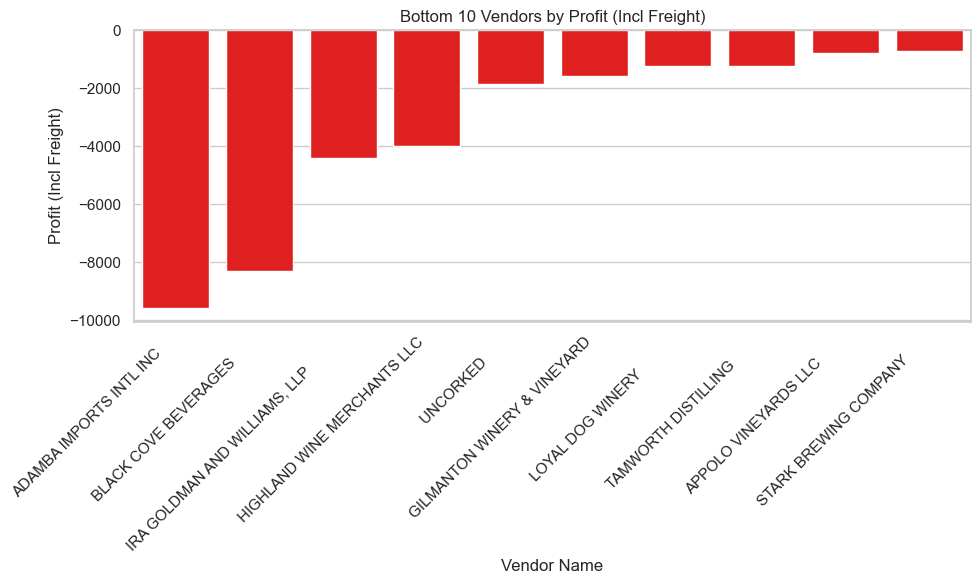

In [20]:
# Step 5: Plot Bottom 10 Vendors
# -------------------------------
plt.figure(figsize=(10,6))
sns.barplot(
    x='vendor_name',
    y='profit_incl_freight',
    data=bottom_vendors,
    color='red'
)
plt.xticks(rotation=45, ha='right')
plt.title('Bottom 10 Vendors by Profit (Incl Freight)')
plt.ylabel('Profit (Incl Freight)')
plt.xlabel('Vendor Name')
plt.tight_layout()
plt.show()